In [1]:
import os
from pathlib import Path

# input_directory = Path("/home/kdemyokhin_1/concept-tree-course-work/articles_triples_cleaned/arxiv-txt-cs")
input_directory = Path("/home/simon/Desktop/concept-tree/concept-tree/process_graph/articles_triples_cleaned/arxiv-txt-cs")

# Получаем список всех txt файлов рекурсивно (включая поддиректории)
input_files = list(input_directory.rglob("*.txt"))

# PICKLED_GRAPHS = "/home/kdemyokhin_1/concept-tree-course-work/pickled_graphs/"
PICKLED_GRAPHS = "/home/simon/Desktop/concept-tree/concept-tree/process_graph/pickled_graphs/"

In [2]:
from directed_graph.graph import Graph

graph = Graph()

## Построение графа из триплетов

In [3]:
import csv
import random

added_edges = set()

for path in random.sample(input_files, 2):
    with open(path, newline='') as csvfile:
        triplets_reader = csv.reader(csvfile, delimiter=";")
        for triplet in triplets_reader:
            agent_1, action, agent_2 = triplet
            edge = (
                agent_1,
                agent_2,
                action,
            )
            if len(agent_1) == 0 or len(agent_2) == 0 or len(action) == 0:
                continue

            if edge not in added_edges:
                added_edges.add(edge)
                if edge[0] not in graph.vertices:
                    graph.add_vertex(edge[0])
                if edge[1] not in graph.vertices:
                    graph.add_vertex(edge[1])
                graph.add_edge(*edge)

### Сохранение дампа графа:

In [4]:
from directed_graph.graph import save_graph

save_graph(graph, PICKLED_GRAPHS+"raw_graph.pickle")

### Подгружаем построенный сырой граф:

In [3]:
del graph

In [4]:
from directed_graph.graph import load_graph

graph = load_graph(PICKLED_GRAPHS+"raw_graph.pickle")

In [5]:
graph.edges

[Edge(sophisticated algorithm <--[make]--> rapid trading decision),
 Edge(sophisticated algorithm <--[make on]--> large volume),
 Edge(these decision <--[hinge on]--> predictive model),
 Edge(scarcity <--[skews of]--> these event),
 Edge(scarcity <--[skews]--> distribution),
 Edge(scarcity <--[skews of]--> label),
 Edge(this imbalance <--[complicates]--> model training),
 Edge(standard machine learning algorithm <--[become towards]--> more frequent label),
 Edge(scarce occurrence <--[make of]--> rare event),
 Edge(imbalanced data <--[refers to]--> dataset),
 Edge(one or more class <--[have]--> significantly greater number),
 Edge(one or more class <--[have of]--> example),
 Edge(classification <--[pose of]--> imbalanced data),
 Edge(classification <--[pose]--> significant challenge),
 Edge(classification <--[pose to]--> traditional classification model),
 Edge(set <--[produce]--> suboptimal classification model),
 Edge(set <--[produce to]--> good coverage),
 Edge(set <--[produce to]-->

## Перебор параметров для кластеризации ребер

### Получение верхней оценки на eps в переборе

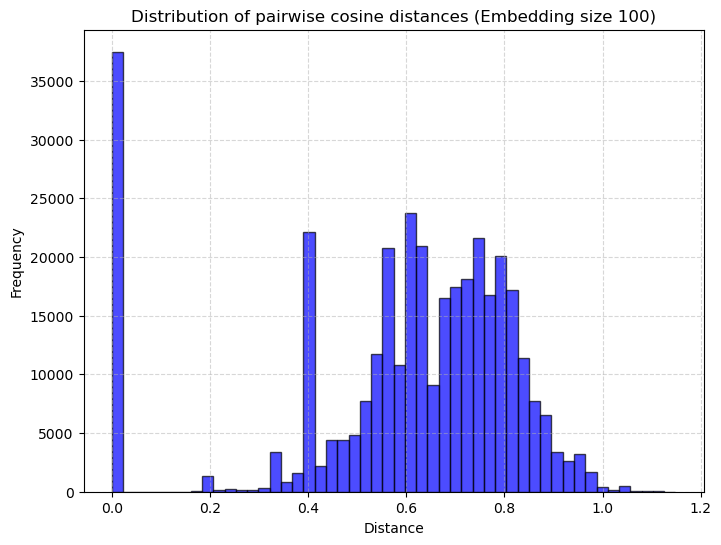

Embedding size 100: Median cosine distance = 0.6417, 90th percentile = 0.8282


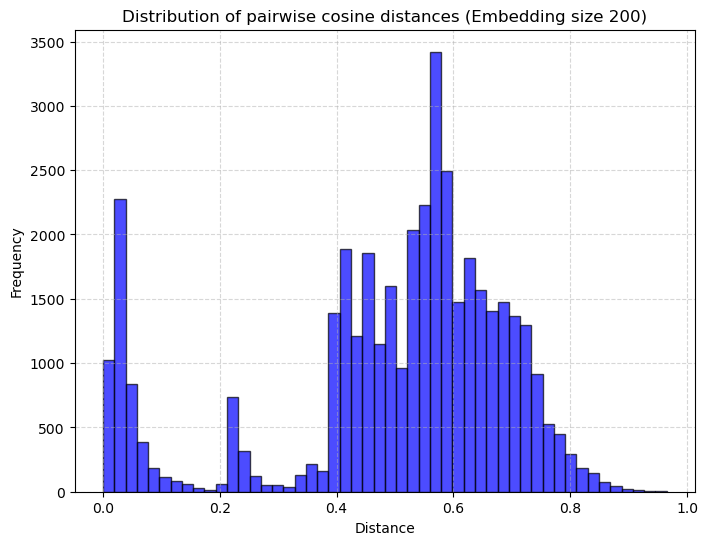

Embedding size 200: Median cosine distance = 0.5531, 90th percentile = 0.7131


{100: {'median_distance': np.float32(0.6417062),
  'percentile_90': np.float32(0.8281681)},
 200: {'median_distance': np.float32(0.5531133),
  'percentile_90': np.float32(0.71305406)}}

In [6]:
from process_graph.edges_clustering import analyze_distance_distributions

analyze_distance_distributions(graph.edges, metric="cosine")

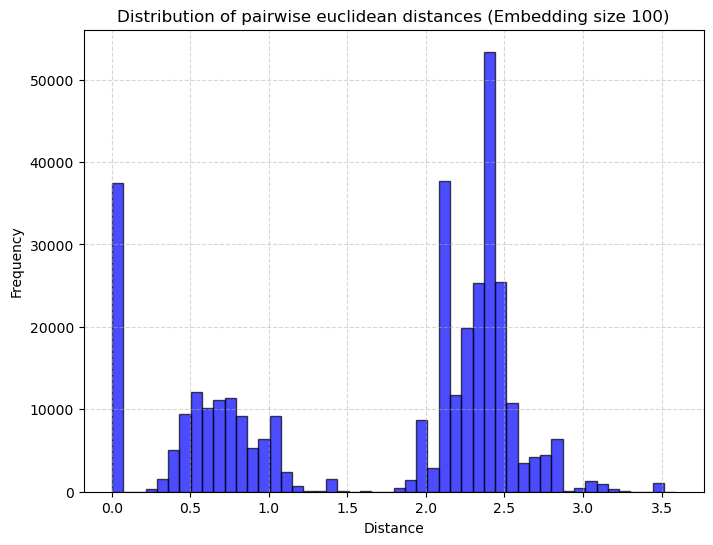

Embedding size 100: Median euclidean distance = 2.1328, 90th percentile = 2.4958


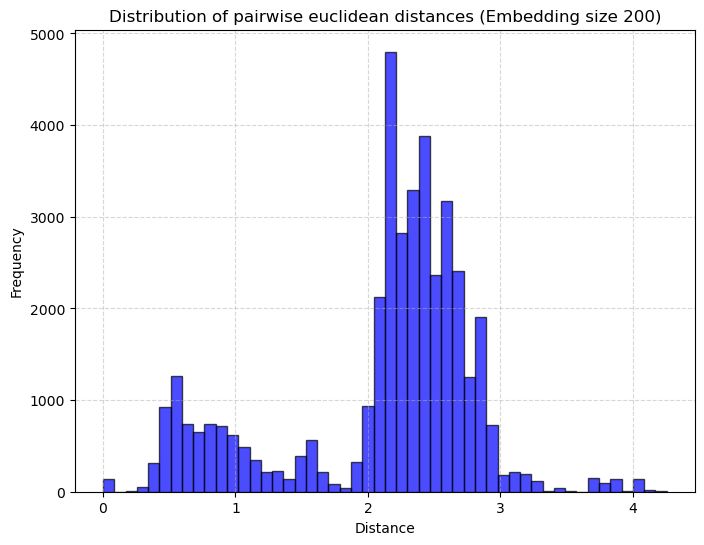

Embedding size 200: Median euclidean distance = 2.3043, 90th percentile = 2.8031


{100: {'median_distance': np.float32(2.1327868),
  'percentile_90': np.float32(2.4958158)},
 200: {'median_distance': np.float32(2.3042572),
  'percentile_90': np.float32(2.8030775)}}

In [7]:
analyze_distance_distributions(graph.edges, metric="euclidean")

In [8]:
from collections import defaultdict

# Инициализация словаря для хранения количества рёбер по размеру эмбеддингов
edges_count_by_size = defaultdict(int)

# Подсчёт количества рёбер для каждого размера эмбеддингов
for edge in graph.edges:
    embedding_size = len(edge.embedding)
    edges_count_by_size[embedding_size] += 1

# Вывод результатов
for size, count in edges_count_by_size.items():
    print(f"Размер эмбеддинга: {size}, Количество рёбер: {count}")

Размер эмбеддинга: 100, Количество рёбер: 842
Размер эмбеддинга: 200, Количество рёбер: 284


In [9]:
from process_graph.edges_clustering import grid_search_cluster_params, compute_connectivity_matrix
import numpy as np

model_param_grid = {
    "DBSCAN": {
        "eps": np.linspace(1, 2.8, 20),
        "min_samples": np.linspace(20, 200, 20, dtype=np.int64),
        "metric": ["euclidean"]
    },
    "AgglomerativeClustering": {
        "n_clusters": np.linspace(10, 100, 1, dtype=np.int64),
        "metric": ["euclidean", "cosine", ""],
        "linkage": ["ward", "complete", "average", "single"],
        "connectivity": [None, compute_connectivity_matrix(graph.edges, [100, 200, 300], "adjacency"), compute_connectivity_matrix(graph.edges, [100, 200, 300], "shortest_path")]
    }
}
embedding_sizes = [100, 200]

In [10]:
    # Поиск оптимальных параметров
best_params, best_scores = grid_search_cluster_params(graph.edges, embedding_sizes, model_param_grid, standardize=False)

Embedding size 100, model=DBSCAN, params={'eps': np.float64(2.136842105263158), 'min_samples': np.int64(29), 'metric': 'euclidean'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(2.136842105263158), 'min_samples': np.int64(38), 'metric': 'euclidean'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(2.136842105263158), 'min_samples': np.int64(48), 'metric': 'euclidean'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(2.136842105263158), 'min_samples': np.int64(57), 'metric': 'euclidean'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(2.136842105263158), 'min_samples': np.int64(67), 'metric': 'euclidean'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(2.13684210

/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 136 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 136 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 136 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 136 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 136 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 136 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

The 'metric' parameter of AgglomerativeClustering must be a str among {'precomputed', 'mahalanobis', 'russellrao', 'canberra', 'l1', 'sokalsneath', 'nan_euclidean', 'sokalmichener', 'cosine', 'dice', 'jaccard', 'chebyshev', 'yule', 'correlation', 'matching', 'haversine', 'hamming', 'manhattan', 'braycurtis', 'cityblock', 'rogerstanimoto', 'minkowski', 'euclidean', 'l2', 'seuclidean', 'sqeuclidean', 'wminkowski'} or a callable. Got '' instead.
The 'metric' parameter of AgglomerativeClustering must be a str among {'precomputed', 'mahalanobis', 'russellrao', 'canberra', 'l1', 'sokalsneath', 'nan_euclidean', 'sokalmichener', 'cosine', 'dice', 'jaccard', 'chebyshev', 'yule', 'correlation', 'matching', 'haversine', 'hamming', 'manhattan', 'braycurtis', 'cityblock', 'rogerstanimoto', 'minkowski', 'euclidean', 'l2', 'seuclidean', 'sqeuclidean', 'wminkowski'} or a callable. Got '' instead.
The 'metric' parameter of AgglomerativeClustering must be a str among {'precomputed', 'mahalanobis', 'russ

/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 77 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 78 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 77 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 77 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 78 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 77 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

The 'metric' parameter of AgglomerativeClustering must be a str among {'precomputed', 'mahalanobis', 'russellrao', 'canberra', 'l1', 'sokalsneath', 'nan_euclidean', 'sokalmichener', 'cosine', 'dice', 'jaccard', 'chebyshev', 'yule', 'correlation', 'matching', 'haversine', 'hamming', 'manhattan', 'braycurtis', 'cityblock', 'rogerstanimoto', 'minkowski', 'euclidean', 'l2', 'seuclidean', 'sqeuclidean', 'wminkowski'} or a callable. Got '' instead.
The 'metric' parameter of AgglomerativeClustering must be a str among {'precomputed', 'mahalanobis', 'russellrao', 'canberra', 'l1', 'sokalsneath', 'nan_euclidean', 'sokalmichener', 'cosine', 'dice', 'jaccard', 'chebyshev', 'yule', 'correlation', 'matching', 'haversine', 'hamming', 'manhattan', 'braycurtis', 'cityblock', 'rogerstanimoto', 'minkowski', 'euclidean', 'l2', 'seuclidean', 'sqeuclidean', 'wminkowski'} or a callable. Got '' instead.
The 'metric' parameter of AgglomerativeClustering must be a str among {'precomputed', 'mahalanobis', 'russ

In [13]:
best_params

{100: {'model': 'DBSCAN',
  'params': {'eps': np.float64(1.9473684210526314),
   'min_samples': np.int64(124),
   'metric': 'euclidean'}},
 200: {'model': 'DBSCAN',
  'params': {'eps': np.float64(1.8526315789473684),
   'min_samples': np.int64(29),
   'metric': 'euclidean'}}}

In [14]:
best_scores

{100: {'Silhouette Score': np.float32(0.6500404),
  'Davies-Bouldin Index': np.float64(1.206540966559327),
  'Calinski-Harabasz Index': np.float32(689.71466),
  'Dunn Index': np.float32(0.8718198),
  'Connectivity Score': 0.004513064133016627,
  'Intra-Cluster Variance': np.float32(0.3824126)},
 200: {'Silhouette Score': np.float32(0.40171278),
  'Davies-Bouldin Index': np.float64(1.6121673536359715),
  'Calinski-Harabasz Index': np.float32(107.83166),
  'Dunn Index': np.float32(0.8383739),
  'Connectivity Score': 0.03028169014084507,
  'Intra-Cluster Variance': np.float32(0.8272082)}}

In [15]:
from process_graph.edges_clustering import cluster_and_evaluate_all_sizes
metrics, edge_label_map = cluster_and_evaluate_all_sizes(graph.edges, best_params, standardize=False)

In [16]:
edge_label_map

{100: {np.str_('make'): np.str_('within'),
  np.str_('skews'): np.str_('within'),
  np.str_('complicates'): np.str_('within'),
  np.str_('have'): np.str_('within'),
  np.str_('pose'): np.str_('within'),
  np.str_('produce'): np.str_('within'),
  np.str_('deliver'): np.str_('within'),
  np.str_('bias'): np.str_('within'),
  np.str_('shown'): np.str_('within'),
  np.str_('mitigate'): np.str_('within'),
  np.str_('duplicating'): np.str_('within'),
  np.str_('address'): np.str_('within'),
  np.str_('combine'): np.str_('within'),
  np.str_('outperformed'): np.str_('within'),
  np.str_('exhibit'): np.str_('within'),
  np.str_('enable'): np.str_('within'),
  np.str_('return'): np.str_('within'),
  np.str_('generates'): np.str_('within'),
  np.str_('considers'): np.str_('within'),
  np.str_('determine'): np.str_('within'),
  np.str_('defined'): np.str_('within'),
  np.str_('concern'): np.str_('within'),
  np.str_('assigns'): np.str_('within'),
  np.str_('designates'): np.str_('within'),
  np.s

In [17]:
cluster_to_words = {}
for emb_size in edge_label_map:
    cluster_to_words[emb_size] = {}
    for label1, label2 in edge_label_map[emb_size].items():
        if label2 not in cluster_to_words[emb_size]:
            cluster_to_words[emb_size][label2] = []
        cluster_to_words[emb_size][label2].append(label1)

In [18]:
cluster_to_words

{100: {np.str_('within'): [np.str_('make'),
   np.str_('skews'),
   np.str_('complicates'),
   np.str_('have'),
   np.str_('pose'),
   np.str_('produce'),
   np.str_('deliver'),
   np.str_('bias'),
   np.str_('shown'),
   np.str_('mitigate'),
   np.str_('duplicating'),
   np.str_('address'),
   np.str_('combine'),
   np.str_('outperformed'),
   np.str_('exhibit'),
   np.str_('enable'),
   np.str_('return'),
   np.str_('generates'),
   np.str_('considers'),
   np.str_('determine'),
   np.str_('defined'),
   np.str_('concern'),
   np.str_('assigns'),
   np.str_('designates'),
   np.str_('requires'),
   np.str_('involve'),
   np.str_('preprocesses'),
   np.str_('guide'),
   np.str_('categorise'),
   np.str_('identify'),
   np.str_('distinguish'),
   np.str_('embed'),
   np.str_('surpass'),
   np.str_('include'),
   np.str_('consider'),
   np.str_('represent'),
   np.str_('identified'),
   np.str_('implemented'),
   np.str_('split'),
   np.str_('offer'),
   np.str_('observe'),
   np.str_('

In [19]:
clusters_amount = {}
for emb_size in cluster_to_words:
    clusters_amount[emb_size]=len(cluster_to_words[emb_size])

In [20]:
clusters_amount

{100: 9, 200: 44}

In [21]:
unique_labels = set()
for edge in graph.edges:
    unique_labels.add(edge.label)

In [22]:
len(unique_labels)

373

In [23]:
from process_graph.edges_clustering import plot_clusters_with_pca

plot_clusters_with_pca(graph.edges, edge_label_map)

In [ ]:
"""
Cluster vertices
"""

from process_graph.squeezing import squeeze

(
    (words_to_cluster, merged_words_map),
    (bigrams_to_cluster, merged_bigrams_map),
    (trigrams_to_cluster, merged_trigrams_map),
) = squeeze((0.4, 0.1, 0.1), graph.vertices.values())

operands could not be broadcast together with shapes (1800,) (900,) : [[[formula th aggregated network layer]]]; whose parameter matrix
operands could not be broadcast together with shapes (1800,) (900,) : [[[formula th large model]]]; whose parameter matrix
operands could not be broadcast together with shapes (2700,) (900,) : [[[formula th layer]]]; whose parameter matrix


In [ ]:
"""
Cluster edges
"""
from process_graph.edges_clustering import cluster_and_evaluate_all_sizes

edge_map, metrics = cluster_and_evaluate_all_sizes(graph.edges, with_metrics=True)

In [ ]:
metrics

{'embedding_size_300': {'Silhouette Score': np.float32(0.4935592),
  'Davies-Bouldin Index': np.float64(1.4662594633483381),
  'Calinski-Harabasz Index': np.float32(49.34576)},
 'embedding_size_600': {'Silhouette Score': np.float32(0.20228788),
  'Davies-Bouldin Index': np.float64(1.5148926834137941),
  'Calinski-Harabasz Index': np.float32(7.719379)}}

In [ ]:
clustered_graph = Graph()

for new_vertice_words in merged_words_map.keys():
    clustered_graph.add_vertex(new_vertice_words, new_vertice_words.split()[:3])
for new_vertice_bigram in merged_bigrams_map.keys():
    clustered_graph.add_vertex(new_vertice_bigram, new_vertice_bigram.split()[:3])
for new_vertice_trigram in merged_trigrams_map.keys():
    clustered_graph.add_vertex(new_vertice_trigram, new_vertice_trigram.split()[:3])

def match_new_vertice(label: str) -> str:
    new_label = str()
    if label in words_to_cluster:
        new_label = words_to_cluster[label]
    elif label in bigrams_to_cluster:
        new_label = bigrams_to_cluster[label]
    elif label in trigrams_to_cluster:
        new_label = trigrams_to_cluster[label]
    return new_label

added_edges = set()  # keeps added_edges in (agent_1, agent_2, label) format

for edge in tqdm.tqdm(graph.edges):
    new_edge = (
        match_new_vertice(edge.agent_1),
        match_new_vertice(edge.agent_2),
        edge_map[edge.label] if edge.label in edge_map else edge.label,
    )
    if new_edge in added_edges:
        continue

    clustered_graph.add_edge(*new_edge)

100%|██████████| 1307/1307 [00:00<00:00, 1377.95it/s]


In [ ]:
print(graph)

print(clustered_graph)

Graph(
	vertices=[Vertex(concept='mobile device', words=['mobile', 'device']), Vertex(concept='shared global model', words=['shared', 'global', 'model']), Vertex(concept='client', words=['client']), Vertex(concept='client private data', words=['client', 'private', 'data']), Vertex(concept='server', words=['server']), Vertex(concept='model aggregation', words=['model', 'aggregation']), Vertex(concept='heterogeneous client', words=['heterogeneous', 'client']), Vertex(concept='federated client', words=['federated', 'client']), Vertex(concept='diverse system resource', words=['diverse', 'system', 'resource']), Vertex(concept='heterogeneous model', words=['heterogeneous', 'model']), Vertex(concept='data distribution', words=['data', 'distribution']), Vertex(concept='high end pc', words=['high', 'end', 'pc']), Vertex(concept='large model', words=['large', 'model']), Vertex(concept='sub model', words=['sub', 'model']), Vertex(concept='previous solution', words=['previous', 'solution']), Verte

In [ ]:
from directed_graph.visualize_graph import visualize_graph_ngrams, visualize_graph_ngrams_with_pca
# visualize_graph_ngrams(clustered_graph)
visualize_graph_ngrams_with_pca(clustered_graph)

Excluded vertices due to inconsistent embedding dimensions: {'[[[formula th aggregated network layer]]]', '[[[formula th large model]]]', '[[[formula th layer]]]'}


In [ ]:
from collections import defaultdict

edge_cluster_to_word_map = defaultdict(list)
for key, value in edge_map.items():
    edge_cluster_to_word_map[value].append(key)
edge_cluster_to_word_map = dict(edge_cluster_to_word_map)


In [ ]:
import json

def print_beautiful_dict(d):
    """Prints a dictionary with pretty formatting."""
    print(json.dumps(d, indent=4, sort_keys=True))

print_beautiful_dict(edge_cluster_to_word_map)

{
    "address": [
        "address"
    ],
    "aggregates": [
        "aggregates"
    ],
    "among": [
        "among"
    ],
    "applies": [
        "apply",
        "applies"
    ],
    "as": [
        "as"
    ],
    "between": [
        "between"
    ],
    "broadcasts": [
        "broadcasts"
    ],
    "captures": [
        "distills",
        "captures",
        "capture"
    ],
    "carry": [
        "carry"
    ],
    "compress": [
        "compress"
    ],
    "conduct": [
        "conduct"
    ],
    "contain via": [
        "compress via",
        "generate via",
        "optimize via",
        "contain via"
    ],
    "decreases below": [
        "decreases below",
        "remains above"
    ],
    "demonstrate of": [
        "have for",
        "distills from",
        "imposes on",
        "train on",
        "distribute of",
        "suffer from",
        "retain of",
        "performs on",
        "assigns to",
        "incur for",
        "formulate as",
       

In [ ]:
len(edge_cluster_to_word_map.keys())

48

In [ ]:
len(edge_cluster_to_word_map.keys())

In [ ]:
from directed_graph.graph import save_graph

save_graph(clustered_graph, "clustered_graph.pickle")